<a href="https://www.kaggle.com/code/nguyentienanh1307/btl-ai?scriptVersionId=174890622" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from torch.utils.data import Dataset
import os
import torch.nn as nn
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Compose, Resize, ToTensor
from sklearn.metrics import confusion_matrix, accuracy_score
import argparse
import shutil
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import cv2

2024-04-30 12:48:38.171047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 12:48:38.171214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 12:48:38.303383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class AnimalDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.image_paths = []
        self.labels = []
        self.categories = ["butterfly", "cat", "chicken", "cow", "dog", "elephant", "horse", "sheep", "spider", "squirrel"]
        self.transform = transform

        if train:
            data_path = os.path.join(root, "train")
            print("--------Train-data---------")
        else:
            data_path = os.path.join(root, "test")
            print()
            print("--------Test-data----------")

        for i, category in enumerate(self.categories):
            data_files = os.path.join(data_path, category)
            print('{}'.format(category), len(os.listdir(data_files)))
            for item in os.listdir(data_files):
                path = os.path.join(data_files, item)
                self.image_paths.append(path)
                self.labels.append(i)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:
class AnimalCNN(nn.Module):
    def _make_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = self._make_block(in_channels=3, out_channels=16)
        self.conv2 = self._make_block(in_channels=16, out_channels=32)
        self.conv3 = self._make_block(in_channels=32, out_channels=64)
        self.conv4 = self._make_block(in_channels=64, out_channels=64)
        self.conv5 = self._make_block(in_channels=64, out_channels=128)
        self.linear_1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(7*7*128, 1024),
            nn.ReLU()
        )
        self.linear_2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
        )
        self.linear_3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.shape[0], -1)
        x = self.linear_1(x)
        x = self.linear_2(x)
        x = self.linear_3(x)
        return x

In [4]:

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
transform = Compose([
    Resize((224, 224)),
    ToTensor()
])
train_set = AnimalDataset(root='../input/train-data/animals', train=True, transform=transform)
test_set = AnimalDataset(root='../input/train-data/animals', train=False, transform=transform)

train_dataloader = DataLoader(
    dataset=train_set,
    batch_size=64,
    num_workers=4,
    drop_last=True,
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=test_set,
    batch_size=64,
    num_workers=4,
    drop_last=False,
    shuffle=False
)

model = AnimalCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

if os.path.exists("/kaggle/working/trained_models"):
    checkpoint = torch.load("/kaggle/working/trained_models/last.pt")
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    start_epoch = checkpoint["epoch"]
else:
    start_epoch = 0

if os.path.isdir('animal'):
    shutil.rmtree('animal')
os.mkdir('animal')
if os.path.isdir("trained_models"):
    shutil.rmtree("trained_models")
os.mkdir("trained_models")
writer = SummaryWriter('animal')
best_loss = 100000
best_epoch = 0

for epoch in range(start_epoch, 100):
    # Train step
    model.train()
    train_loss = []
    progress_bar = tqdm(train_dataloader, colour="cyan")
    for i, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss_value = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss_value.backward()
        train_loss.append(loss_value.item())

        # Optimize
        optimizer.step()
        progress_bar.set_description(
            "Epoch {}. Iteration {}/{} Loss {}. Lr: {}".format(epoch + 1, i + 1, len(train_dataloader),
                                                               np.mean(train_loss),
                                                               optimizer.param_groups[-1]['lr']))
        writer.add_scalar("Train/Loss", np.mean(train_loss), i + epoch * len(train_dataloader))

    # Validation step
    all_predictions = []
    all_labels = []
    test_loss = []

    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss_value = criterion(outputs, labels)
            test_loss.append(loss_value.item())
            predictions = torch.argmax(outputs, dim=1)
            all_predictions.extend(predictions.tolist())
            all_labels.extend(labels.tolist())
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        acc = accuracy_score(all_labels, all_predictions)
        writer.add_scalar("Valid/Loss", np.mean(test_loss), epoch)
        writer.add_scalar("Valid/Acc", acc, epoch)
        print("Epoch {}. Accuracy {}".format(epoch + 1, acc))
    checkpoint = {
        "epoch": epoch + 1,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    torch.save(checkpoint, os.path.join("trained_models", "last.pt"))
    if np.mean(test_loss) < best_loss:
        best_loss = np.mean(test_loss)
        best_epoch = epoch
        torch.save(checkpoint, os.path.join("trained_models", "best.pt"))
#     if epoch - best_epoch == 5:  # Early Stopping
#         break

--------Train-data---------
butterfly 1902
cat 1508
chicken 2790
cow 1684
dog 2500
elephant 1306
horse 2357
sheep 1638
spider 2500
squirrel 1680

--------Test-data----------
butterfly 210
cat 160
chicken 308
cow 182
dog 490
elephant 140
horse 266
sheep 182
spider 476
squirrel 182


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 1. Accuracy 0.4052388289676425


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 2. Accuracy 0.39021571648690295


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 3. Accuracy 0.5573959938366718


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 4. Accuracy 0.5570107858243452


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 5. Accuracy 0.5851309707241911


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 6. Accuracy 0.6201848998459168


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 7. Accuracy 0.6563944530046225


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 8. Accuracy 0.634437596302003


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 9. Accuracy 0.7091679506933745


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 10. Accuracy 0.6868258859784283


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 11. Accuracy 0.7245762711864406


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 12. Accuracy 0.6640986132511556


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 13. Accuracy 0.7318952234206472


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 14. Accuracy 0.7060862865947611


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 15. Accuracy 0.7673343605546995


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 16. Accuracy 0.7515408320493067


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 17. Accuracy 0.75


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 18. Accuracy 0.762326656394453


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 19. Accuracy 0.7461479198767335


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 20. Accuracy 0.7769645608628659


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 21. Accuracy 0.7942989214175655


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 22. Accuracy 0.7785053929121726


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 23. Accuracy 0.7950693374422187


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 24. Accuracy 0.7257318952234206


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 25. Accuracy 0.7958397534668721


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 26. Accuracy 0.774653312788906


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 27. Accuracy 0.7696456086286595


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 28. Accuracy 0.7877503852080123


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 29. Accuracy 0.7823574730354391


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 30. Accuracy 0.7815870570107858


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 31. Accuracy 0.8158705701078582


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 32. Accuracy 0.736517719568567


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 33. Accuracy 0.7835130970724191


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 34. Accuracy 0.7889060092449923


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 35. Accuracy 0.8012326656394453


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 36. Accuracy 0.8050847457627118


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 37. Accuracy 0.7889060092449923


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 38. Accuracy 0.8170261941448382


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 39. Accuracy 0.8081664098613252


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 40. Accuracy 0.8147149460708782


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 41. Accuracy 0.7862095531587057


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 42. Accuracy 0.7850539291217258


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 43. Accuracy 0.8181818181818182


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 44. Accuracy 0.8062403697996918


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 45. Accuracy 0.802773497688752


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 46. Accuracy 0.8039291217257319


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 47. Accuracy 0.8177966101694916


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 48. Accuracy 0.801617873651772


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 49. Accuracy 0.7889060092449923


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 50. Accuracy 0.810477657935285


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 51. Accuracy 0.8158705701078582


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 52. Accuracy 0.8166409861325116


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 53. Accuracy 0.8308936825885979


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 54. Accuracy 0.7954545454545454


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 55. Accuracy 0.7923728813559322


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 56. Accuracy 0.8054699537750385


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 57. Accuracy 0.8050847457627118


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 58. Accuracy 0.8212634822804314


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 59. Accuracy 0.8231895223420647


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 60. Accuracy 0.8108628659476117


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 61. Accuracy 0.826271186440678


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 62. Accuracy 0.811633281972265


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 63. Accuracy 0.811633281972265


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 64. Accuracy 0.8378274268104776


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 65. Accuracy 0.8270416024653313


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 66. Accuracy 0.8020030816640986


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 67. Accuracy 0.8177966101694916


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 68. Accuracy 0.8170261941448382


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 69. Accuracy 0.8135593220338984


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 70. Accuracy 0.8050847457627118


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 71. Accuracy 0.8231895223420647


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 72. Accuracy 0.8174114021571649


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 73. Accuracy 0.8174114021571649


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 74. Accuracy 0.8054699537750385


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 75. Accuracy 0.8181818181818182


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 76. Accuracy 0.8066255778120185


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 77. Accuracy 0.8301232665639445


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 78. Accuracy 0.8147149460708782


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 79. Accuracy 0.8054699537750385


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 80. Accuracy 0.8162557781201849


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 81. Accuracy 0.8177966101694916


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 82. Accuracy 0.8324345146379045


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 83. Accuracy 0.8228043143297381


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 84. Accuracy 0.8258859784283513


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 85. Accuracy 0.8151001540832049


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 86. Accuracy 0.8228043143297381


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 87. Accuracy 0.8120184899845917


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 88. Accuracy 0.825115562403698


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 89. Accuracy 0.812788906009245


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 90. Accuracy 0.8266563944530047


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 91. Accuracy 0.8166409861325116


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 92. Accuracy 0.8235747303543913


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 93. Accuracy 0.8335901386748844


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 94. Accuracy 0.8070107858243452


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 95. Accuracy 0.8081664098613252


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 96. Accuracy 0.8247303543913713


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 97. Accuracy 0.8204930662557781


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 98. Accuracy 0.8308936825885979


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 99. Accuracy 0.8278120184899846


  0%|          | 0/310 [00:00<?, ?it/s]

Epoch 100. Accuracy 0.8058551617873652


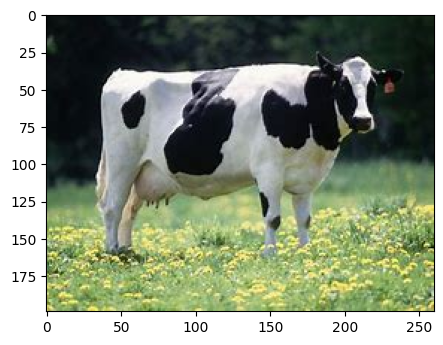

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


The image is cow with 99.99996185302734%


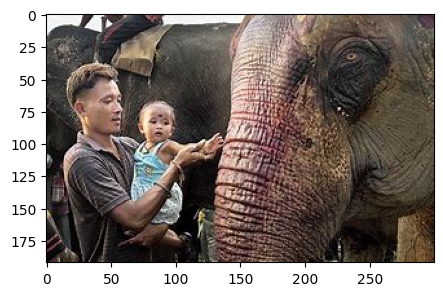

The image is elephant with 99.96782684326172%


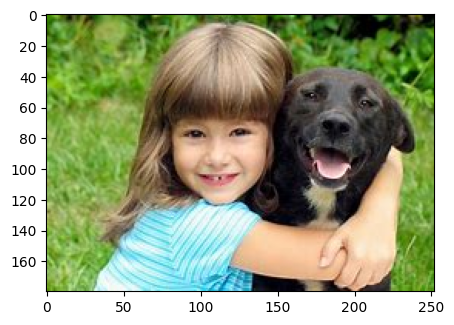

The image is dog with 99.99982452392578%


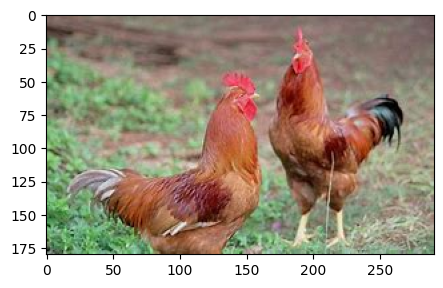

The image is chicken with 100.0%


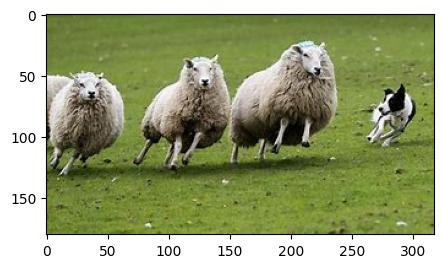

The image is sheep with 100.0%


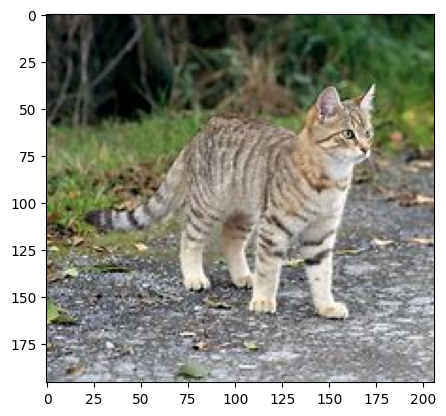

The image is squirrel with 90.80125427246094%


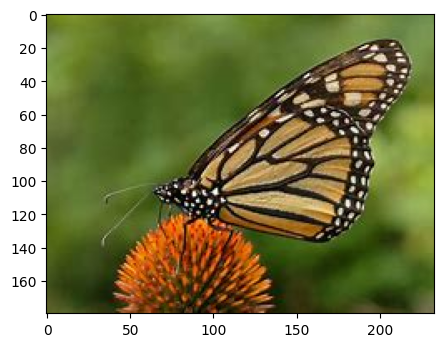

The image is butterfly with 100.0%


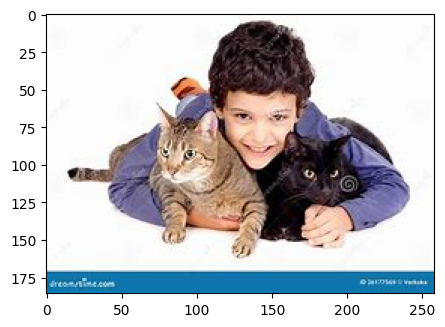

The image is dog with 76.22013092041016%


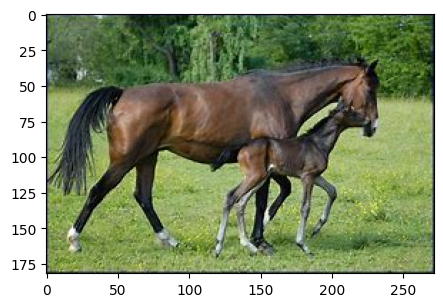

The image is horse with 99.98297882080078%


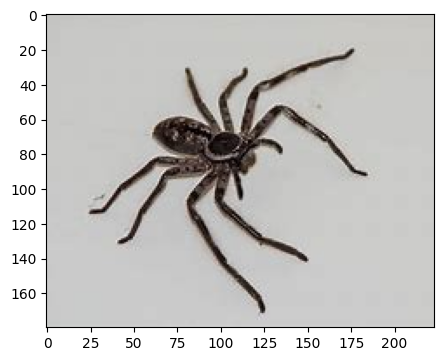

The image is spider with 100.0%


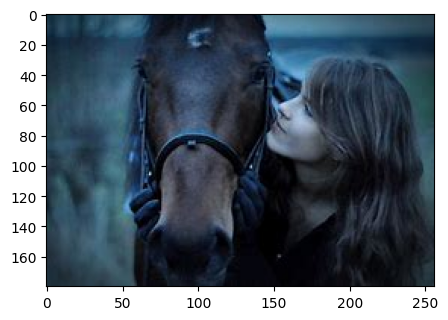

The image is horse with 49.252708435058594%


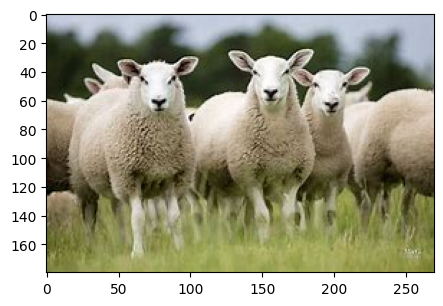

The image is sheep with 100.0%


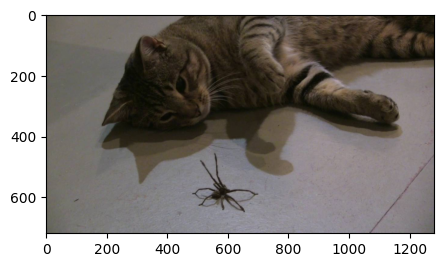

The image is dog with 75.38668060302734%


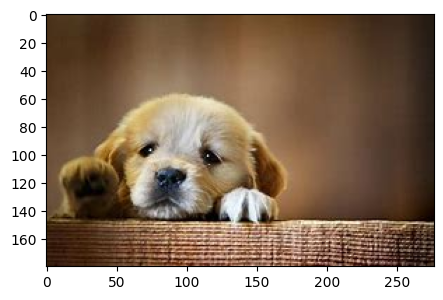

The image is dog with 99.99071502685547%


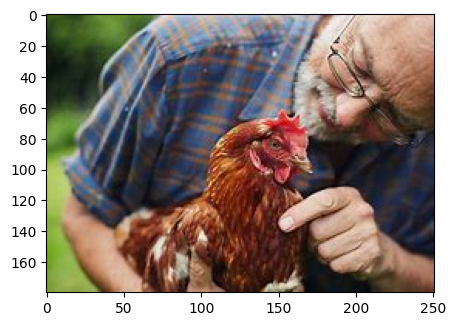

The image is chicken with 99.64319610595703%


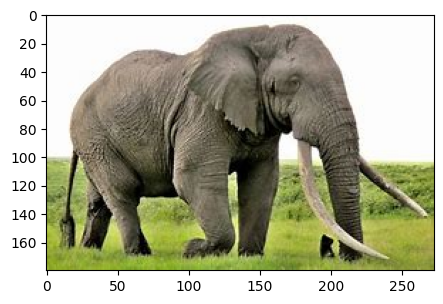

The image is elephant with 100.0%


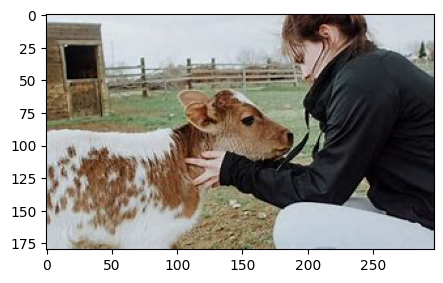

The image is elephant with 34.144615173339844%


In [5]:
classes = ["butterfly", "cat", "chicken", "cow", "dog", "elephant", "horse", "sheep", "spider", "squirrel"]
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
model = AnimalCNN(num_classes=10).to(device)
checkpoint = torch.load("/kaggle/working/trained_models/best.pt")
model.load_state_dict(checkpoint["model"])
model.eval()
data_files = "/kaggle/input/test-animal/animal-test"

for item in os.listdir(data_files):
    path = os.path.join(data_files, item)
    image = cv2.imread(path)   # BGR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tmp = image
    plt.figure(figsize=(5,5))
    plt.imshow(tmp)
    plt.show()
    
    image = cv2.resize(image, (224, 224)) / 255
    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image).float()
    image = image.to(device)
    softmax = torch.nn.Softmax()
    with torch.no_grad():
        outputs = model(image)
        probabilities = softmax(outputs)
    idx = torch.argmax(probabilities)
    print("The image is {} with {}%".format(classes[idx], probabilities[0][idx]*100))
    